In [230]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import gc
import pickle
import concurrent.futures

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

RND_STATE = 100412

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Configuration

In [3]:
# weather links
# ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [4]:
WEATHER_API_KEY = ''

In [5]:
STARTING_DATE = '2017-03-01'
END_DATE = '2018-03-01'

In [6]:
DATA_FOLDER = 'historical_data'
DICT_FOLDER = 'dictionaries'
WEATHER_FOLDER = 'weather_data'

In [7]:
DATA_FILE = 'merged_data.csv'

In [8]:
CLF_FILE = 'classifiers.data'

## Merging and loading data

### Loading flights data

In [9]:
def get_file_list(folder_name):
    return glob.glob(folder_name + '/*.csv')

In [10]:
def read_csv(file_name):
    file_data = pd.read_csv(file_name, dtype={'CANCELLATION_CODE': str}, parse_dates=True)
    file_data['FL_DATE'] = pd.to_datetime(file_data.FL_DATE)
    return file_data

In [11]:
def read_csv_backup(file_name):
    file_data = pd.read_csv(file_name, dtype={'cancellation_code': str}, parse_dates=True)
    file_data['fl_date'] = pd.to_datetime(file_data.fl_date)
    file_data = file_data.drop(['Unnamed: 0'], axis = 1)
    return file_data

In [12]:
def gather_data(folder_name):
    file_list = get_file_list(folder_name)
    
    files_data = read_csv(file_list[0])
    for file in log_progress(file_list[1:], every=1):
        tmp = read_csv(file)
        files_data = pd.concat([files_data, tmp])
        del tmp
        
    files_data = files_data.reindex()
    files_data.columns = map(str.lower, files_data.columns)
    return files_data

In [13]:
def append_city_names(files_data, dict_folder_name):
    files_data_df = files_data.copy()
    city_info = pd.read_csv(dict_folder_name + '/city_codes_info.csv')
    city_info['Description'] =  city_info['Description'].str.replace(',.*|\/.*| City', '')
    
    city_info.columns = ['origin_city_market_id', 'origin_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='origin_city_market_id')
    
    city_info.columns = ['dest_city_market_id', 'dest_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='dest_city_market_id')
    
    del city_info
    
    return files_data_df

In [14]:
def load_data(folder_name, dict_folder_name):
    files_data = gather_data(folder_name)
    files_data = files_data.sort_values(by='fl_date')
    files_data = files_data.dropna(thresh=9)
    files_data = append_city_names(files_data, dict_folder_name)
    return files_data.reindex()

In [ ]:
data = load_data(DATA_FOLDER, DICT_FOLDER)

In [ ]:
data.to_csv(DATA_FILE)

### Loading weather data

In [15]:
def get_data_city_names(data_df):
    return list(set(list(data['origin_city_name'].values) + list(data['dest_city_name'].values)))

In [16]:
def load_city_codes(dict_folder_name):
    tmp = pd.read_csv(dict_folder_name + '/weather_city_codes_info.csv')
    tmp['name'] = tmp['name'].str.lower()
    tmp['name'] = tmp['name'].str.replace(',.*|\/.*| city', '')
    tmp['name'] = tmp['name'].str.strip()
    return tmp

In [17]:
def get_weather_city_codes(data_df, dict_folder_name):
    weather_cities_codes = load_city_codes(dict_folder_name)
    data_city_names = get_data_city_names(data_df)
    
    processed_cities = []
    failed_cities = []
    for city in data_city_names:
        city_data = weather_cities_codes[weather_cities_codes['name'].str.contains(city.lower())]
        if len(city_data) == 0:
            failed_cities.append(city)
        else:
            processed_cities.append({'name': city, 'weather_id': city_data['id'].values[0]})
    return processed_cities, failed_cities

In [18]:
def get_weather_for_city(city_info, start_date, end_date, api_key, limit=1000, offset=0):
    req_url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid={0}&startdate={1}&enddate={2}&limit={3}&offset={4}'
    req_url = req_url.format(city_info['weather_id'], start_date, end_date, limit, offset)
    
    result_json = requests.get(req_url, headers={'token': api_key}, timeout=20)
    result_json = json.loads(result_json.content)
    result_data = pd.DataFrame(result_json['results'])
    
    if result_json['metadata']['resultset']['count'] > offset + limit:
        return pd.concat([result_data, get_weather_for_city(city_info, start_date, end_date, api_key, limit, offset + limit)])
    else:
        return result_data

In [19]:
def save_weather_data(data_df, dict_folder_name, save_folder, start_date, end_date, api_key):
    weather_city_codes, error_cities = get_weather_city_codes(data_df, dict_folder_name)
    
    for city in log_progress(weather_city_codes, every=1):
        try:
            city_weather = get_weather_for_city(city, start_date, end_date, api_key)
            city_weather.to_csv(save_folder + '/' + city['name'] + '.csv')
        except Exception as e:
            error_cities.append(city)
            print(e)
    return weather_city_codes, error_cities

In [ ]:
ok, err = save_weather_data(data, DICT_FOLDER, WEATHER_FOLDER, STARTING_DATE, END_DATE, WEATHER_API_KEY)

In [20]:
def filter_data_by_available_weather(data_df, weather_data_folder):
    city_list = get_file_list(weather_data_folder)
    fixed_city_list = []
    for city in city_list:
        fixed_city_list.append(city.replace(weather_data_folder + '/', '').replace('.csv', ''))
    
    tmp_df = data_df[(data_df['origin_city_name'].isin(fixed_city_list)) | (data_df['dest_city_name'].isin(fixed_city_list))]
    return tmp_df, city_list 

In [21]:
def read_weather_file(weather_data_folder, weather_file_path):
    weather_data = pd.read_csv(weather_file_path)
    weather_data['date'] = pd.to_datetime(weather_data.date)
    weather_data = weather_data.drop(['Unnamed: 0', 'attributes', 'station'], axis=1)
    weather_data = weather_data.rename(columns={'date': 'fl_date'})
    weather_data = weather_data.drop_duplicates(["fl_date", "datatype"])
    weather_data = weather_data.pivot_table(weather_data, index='fl_date', columns='datatype', aggfunc=sum, fill_value=0)
    weather_data = weather_data.reset_index()
    weather_data_value = weather_data['value'].copy()
    weather_data_value['fl_date'] = weather_data['fl_date']
    del weather_data
    selected_cols = ['fl_date', 'AWND', 'SNOW', 'SNWD', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11']
    available_cols = list(set(weather_data_value.columns).intersection(selected_cols))
    na_cols = list(set(selected_cols) - set(available_cols))
    weather_data_value = weather_data_value[available_cols]
    
    for na_col in na_cols:
        weather_data_value[na_col] = None
    
    weather_data_value = weather_data_value.rename({'SNOW': 'snowfall_mm', 'SNWD': 'snow_depth_mm', 'AWND': 'avg_wind_ms', 'WT08': 'smoke', 'WT01': 'fog', 'WT03': 'thunder'})
    weather_data_value['city_name'] = weather_file_path.replace(weather_data_folder + '/', '').replace('.csv', '')
    
    return weather_data_value

In [22]:
def merge_data_with_weather(data_df, weather_data_folder):
    filtered_df, city_list = filter_data_by_available_weather(data_df, weather_data_folder)
    dfs = []
    
    for city in log_progress(city_list, every=1):
        tmp = read_weather_file(weather_data_folder, city)
        tmp = tmp.rename(columns={'city_name': 'origin_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'origin_city_name']))
        tmp = tmp.rename(columns={'origin_city_name': 'dest_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'dest_city_name']))
        del tmp
        gc.collect()
        
    final_df = pd.concat(dfs)
    final_df = final_df.sort_values(by=['fl_date', 'origin_city_name', 'dest_city_name'])
    return final_df

In [ ]:
data = merge_data_with_weather(data, WEATHER_FOLDER)

In [ ]:
data.to_csv(DATA_FILE)

## Preprocessing data 

In [62]:
data = read_csv_backup(DATA_FILE)

In [63]:
def get_dependent_variable_value(cancelled, cancelled_code, dep_delay_new):
    if cancelled == 1 or cancelled_code != 'E':
        return 'cancelled_flight'
    if dep_delay_new > 360:
        return 'extra_long_delay'
    if dep_delay_new > 180:
        return 'long_delay'
    if dep_delay_new > 45:
        return 'moderate_delay'
    return 'no_delay'

In [64]:
def preprocess_data(file_data):
    data_df = file_data.copy()
    data_df = data_df.drop(['origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id', 'dest_airport_id', 'dest_airport_seq_id', 'dest_city_market_id', 'year', 'unnamed: 28'], axis=1)
    data_df = data_df.fillna(value={'cancellation_code': 'E'})
    data_df = data_df.fillna(0)
    data_df['fog'] = list(map(int , (data_df['WT01'] + data_df['WT02']).values > 0))
    data_df['hail'] = list(map(int , (data_df['WT04'] + data_df['WT05']).values > 0))
    data_df['damaging_wind'] = list(map(int , (data_df['WT10'] + data_df['WT11']).values > 0))
    data_df = data_df.drop(['WT01', 'WT02', 'WT04', 'WT05', 'WT06', 'WT10', 'WT11'], axis=1)
    data_df = data_df.rename(columns={'SNOW': 'snowfall', 'SNWD': 'snow_depth', 'AWND': 'average_wind_speed','WT03': 'thunder', 'WT07': 'dust', 'WT08': 'haze', 'WT09': 'snow'})
    
    data_df['cancellation_code'] = list(map(str, data_df['cancellation_code']))
    data_df['carrier'] = list(map(str, data_df['carrier']))
    data_df['dest'] = list(map(str, data_df['dest']))
    data_df['dest_city_name'] = list(map(str, data_df['dest_city_name']))
    data_df['origin'] = list(map(str, data_df['origin']))
    data_df['origin_city_name'] = list(map(str, data_df['origin_city_name']))
    data_df['cancelled'] = list(map(int, data_df['cancelled']))
    data_df['diverted'] = list(map(int, data_df['diverted']))
    
    with concurrent.futures.ProcessPoolExecutor(16) as pool:
        data_df['status'] = list(pool.map(get_dependent_variable_value, data_df['cancelled'], data_df['cancellation_code'], data_df['dep_delay_new'], chunksize=1_000))
    return data_df

In [65]:
data = preprocess_data(data)

## Analysis with additional data

Overall data info

In [66]:
data.describe()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,crs_dep_time,...,fl_num,late_aircraft_delay,month,nas_delay,quarter,security_delay,weather_delay,fog,hail,damaging_wind
count,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,...,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06
mean,2.797055e+01,5.401027e-01,2.967996e+00,1.996743e-01,2.674550e-03,1.417231e-01,7.290137e-04,1.352640e-02,3.687214e+00,1.332838e+03,...,2.222141e+03,4.380498e+00,7.430768e+00,2.367079e+00,2.778629e+00,1.760090e-02,4.958002e-01,3.588335e-01,5.467817e-03,4.311938e-03
std,2.551131e+01,8.485501e+00,2.975954e+01,3.997556e-01,5.164685e-02,3.487659e-01,2.699041e-02,1.155138e-01,2.873237e+01,4.901060e+02,...,1.727191e+03,2.211855e+01,2.861298e+00,1.517216e+01,9.802593e-01,1.434897e+00,1.065670e+01,4.796583e-01,7.374226e-02,6.552363e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.200000e+02,...,8.460000e+02,0.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.325000e+03,...,1.765000e+03,0.000000e+00,7.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.735000e+03,...,3.083000e+03,0.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.073000e+03,8.230000e+02,1.626000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.810000e+03,2.359000e+03,...,7.439000e+03,1.756000e+03,1.200000e+01,1.605000e+03,4.000000e+00,8.270000e+02,1.587000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Correlations

In [67]:
data.corr()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,crs_dep_time,...,fl_num,late_aircraft_delay,month,nas_delay,quarter,security_delay,weather_delay,fog,hail,damaging_wind
average_wind_speed,1.000000,0.020475,0.003610,0.016132,0.024853,0.015841,0.027020,0.045726,0.004003,-0.003864,...,-0.003611,0.006299,-0.099981,0.005490,-0.095455,-0.001895,0.003766,0.013802,0.035896,0.010429
snowfall,0.020475,1.000000,0.398069,-0.029398,-0.003262,0.005742,0.117315,0.037992,0.005786,-0.000082,...,0.013806,0.006976,0.014339,0.008094,0.001422,0.000196,0.011704,0.031742,0.029591,-0.002844
snow_depth,0.003610,0.398069,1.000000,-0.048602,-0.005116,-0.008279,0.059578,0.007379,0.002162,0.004208,...,-0.003125,0.000601,-0.005430,0.001638,-0.025987,0.001629,0.005594,-0.000810,0.016864,-0.003448
thunder,0.016132,-0.029398,-0.048602,1.000000,0.034769,0.116344,-0.013412,0.015514,0.019167,-0.001374,...,-0.022956,0.050081,-0.125450,0.057899,-0.099691,0.000153,0.025595,0.351190,0.067620,0.049227
dust,0.024853,-0.003262,-0.005116,0.034769,1.000000,0.120741,-0.000476,0.001264,0.000590,0.001411,...,-0.000131,0.007047,-0.003034,0.007999,0.002658,-0.000366,0.006133,-0.021051,-0.002883,0.004001
haze,0.015841,0.005742,-0.008279,0.116344,0.120741,1.000000,0.012176,0.006990,0.005336,-0.002471,...,-0.001689,0.011300,0.004419,0.017414,0.006345,0.000224,0.008736,0.231572,0.002873,0.000387
snow,0.027020,0.117315,0.059578,-0.013412,-0.000476,0.012176,1.000000,0.015532,0.003221,-0.000096,...,0.013880,0.004567,-0.004094,0.006759,-0.011792,0.000892,0.008752,0.031189,0.004027,0.001858
cancelled,0.045726,0.037992,0.007379,0.015514,0.001264,0.006990,0.015532,1.000000,-0.015027,0.012305,...,-0.001015,-0.023191,-0.001103,-0.018269,-0.009463,-0.001436,-0.005448,0.031566,0.000550,0.013245
carrier_delay,0.004003,0.005786,0.002162,0.019167,0.000590,0.005336,0.003221,-0.015027,1.000000,0.014480,...,0.019843,0.051375,-0.013335,0.020539,-0.011813,-0.000749,-0.002219,0.012001,0.001725,0.000672
crs_dep_time,-0.003864,-0.000082,0.004208,-0.001374,0.001411,-0.002471,-0.000096,0.012305,0.014480,1.000000,...,0.025200,0.108690,-0.002847,0.028504,-0.003176,0.002960,0.014277,-0.001334,0.001102,0.002236


In [68]:
def check_correlations(data_df, min_v=0.7):
    corr = data_df.corr()
    corrs = []
    for i in corr:
        for j in corr.index[corr[i] >= min_v]:
            if i != j and j not in corrs and i not in corrs:
                corrs.append(j)
                print("%s-->%s: r^2=%f" % (i,j, corr[i][corr.index == j].values[0]))
    if len(corrs) == 0:
        print('Everything is perfect')

In [69]:
check_correlations(data)

carrier_delay-->dep_delay_new: r^2=0.713772
month-->quarter: r^2=0.959306


Plotting data

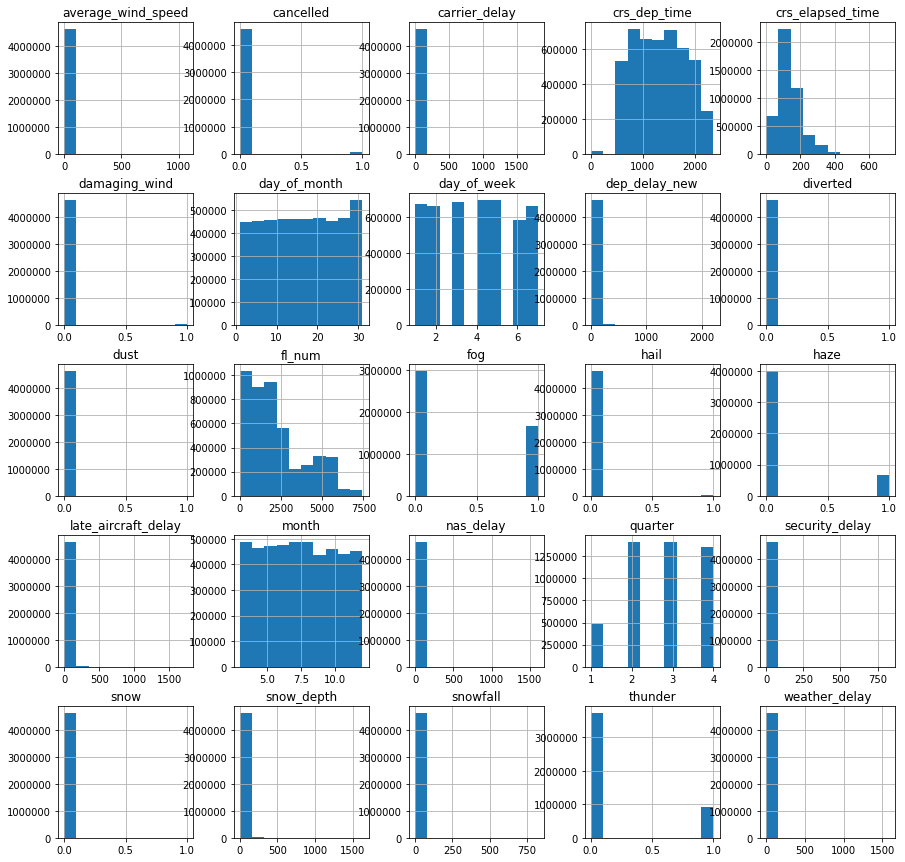

In [70]:
data.hist(figsize=(15, 15));

Plotting classes

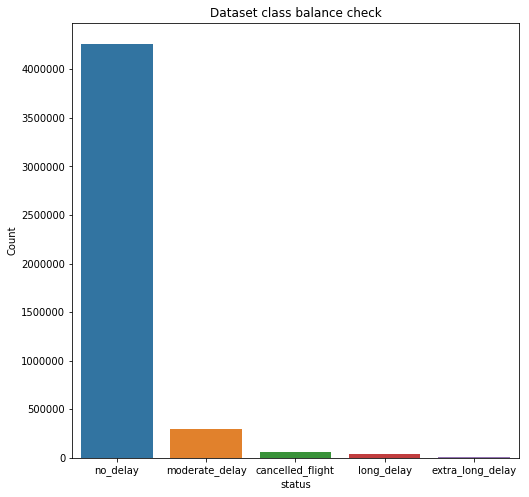

In [71]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = data.status)
ax.set_title('Dataset class balance check')
ax.set_ylabel('Count')
plt.show()

huge imbalance here

Day / delay

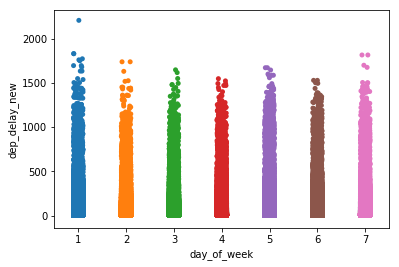

In [72]:
sns.stripplot(x="day_of_week", y="dep_delay_new", data=data, jitter=True)

Month / Delay

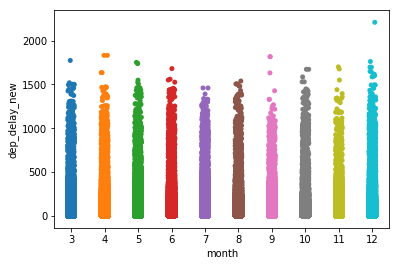

In [73]:
sns.stripplot(x="month", y="dep_delay_new", data=data, jitter=True)

Flights per airline

In [74]:
airlines_group = data[['status', 'carrier']]
airlines_group_num = airlines_group.groupby(['carrier']).size()
airlines_group = data[['status', 'carrier']]
airlines_group = airlines_group[(airlines_group['status'] != 'no_delay') & (airlines_group['status'] != 'short_delay')]
airlines_group_delays_num = airlines_group.groupby(['carrier']).size()
delay_info = pd.DataFrame({'Carrier': np.unique(airlines_group.carrier.values), 'Number of flights': airlines_group_num.values, 'Number of delays': airlines_group_delays_num.values})

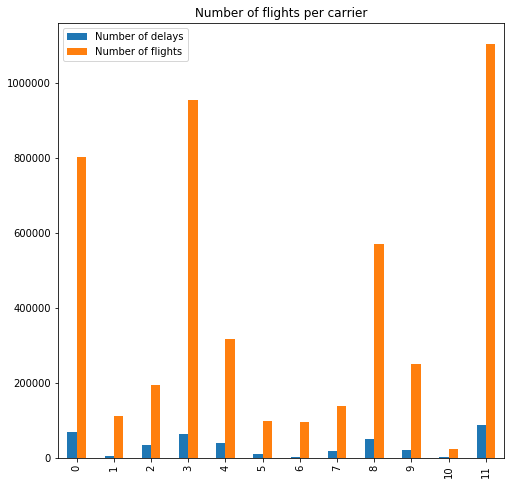

In [75]:
delay_info.plot(kind='bar', figsize=(8, 8), title = 'Number of flights per carrier')

Delay ratings

In [76]:
delay_info['Delay index'] = delay_info['Number of delays'] / delay_info['Number of flights']

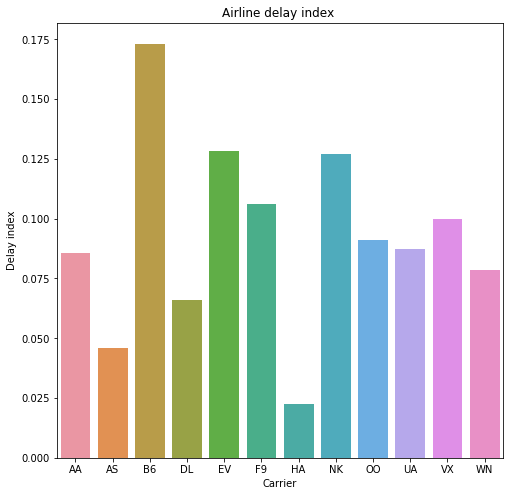

In [77]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x="Carrier", y="Delay index", data=delay_info)
ax.set_title('Airline delay index ')
plt.show()

## Additional preprocessing

In [263]:
data2 = data[data['origin'] == 'ALB']

In [293]:
working_df = data

In [294]:
def additional_preprocessing(data_df):
    data_info = data_df.copy()
    data_info = data_info.drop(['cancellation_code', 'cancelled', 'carrier_delay', 'dep_delay_new', 'late_aircraft_delay', 'nas_delay', 'security_delay', 'weather_delay', 'diverted', 'origin_city_name', 'dest_city_name'], axis = 1)
    
    data_info = data_info.drop(['snowfall', 'snow_depth', 'thunder', 'dust', 'haze', 'snow', 'fog', 'hail', 'damaging_wind'], axis = 1)
    
    data_info['crs_dep_time'] = list(map(int, working_df['crs_dep_time'].values / 100))
    
    return data_info

In [295]:
working_df = additional_preprocessing(working_df)

## Processing

In [267]:
def add_airline_delay_index(carrier):
    return delay_info[delay_info['Carrier'] == carrier]['Delay index'].values[0]

In [268]:
def process_data(data_df):
    data_info = data_df.copy()
    
    airlines_group = data_info[['status', 'carrier']]
    airlines_group_num = airlines_group.groupby(['carrier']).size()
    airlines_group = data_info[['status', 'carrier']]
    airlines_group = airlines_group[(airlines_group['status'] != 'no_delay') & (airlines_group['status'] != 'short_delay')]
    airlines_group_delays_num = airlines_group.groupby(['carrier']).size()
    delay_info = pd.DataFrame({'Carrier': np.unique(airlines_group.carrier.values), 'Number of flights': airlines_group_num.values, 'Number of delays': airlines_group_delays_num.values})
    delay_info['Delay index'] = delay_info['Number of delays'] / delay_info['Number of flights']
    
    with concurrent.futures.ProcessPoolExecutor(16) as pool:
        data_info['airline_delay_index'] = list(pool.map(add_airline_delay_index, data_info['carrier'], chunksize=1_000))
    
    data_info = pd.get_dummies(data_info, columns=['origin', 'dest', 'carrier', 'tail_num'])
    data_info['day_of_year'] = (data_info['fl_date'] - data_info['fl_date'].min())  / np.timedelta64(1,'D')
    data_info = data_info.drop(['fl_date'], axis=1)
    
    return data_info

In [269]:
working_df = process_data(working_df)

## Train test split

In [270]:
X_train, X_test, y_train, y_test = train_test_split(working_df.loc[:, working_df.columns != 'status'], working_df['status'], test_size = 0.2, random_state = RND_STATE)

## Predictions

In [271]:
classifiers = []

In [272]:
class ModelTester():
    def __init__(self, parameters, model, scoring='f1_macro', njobs=-1, cv=3):
        self.cv = GridSearchCV(model, param_grid=parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self, Xtrain, ytrain, Xtest, ytest):
        self.cv.fit(Xtrain, ytrain);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict(Xtest)
        print('F1 (micro) score on test sample:', f1_score(ytest, y_predicted, average='micro'))
        print('F1 (macro) score on test sample:', f1_score(ytest, y_predicted, average='macro'))
        
    def best_estimator(self):
        return self.cv.best_estimator_

### Random Forest

In [273]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None], 'n_estimators': [30, 40]}

mt = ModelTester(parameters = param, model = RandomForestClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
rf_clf = mt.best_estimator()
classifiers.append({'name': 'Random Forest Classifier', 'clf': rf_clf})

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  6.4min finished


Best score cv:  0.5564839639936389
Params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 64, 'max_features': 'log2', 'n_estimators': 40}
F1 (micro) score on test sample: 0.9473436765397273
F1 (macro) score on test sample: 0.7505874635971532


### SVC

In [275]:
param = {'C': np.linspace(0.01, 0.03, num=2), 
              'class_weight':['balanced', None], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None]}

mt = ModelTester(parameters = param, model = SVC(random_state=RND_STATE, cache_size=2048))
# mt.test_model(X_train, y_train, X_test, y_test)
# svc_clf = mt.best_estimator()
# classifiers.append({'name': 'SVC', 'clf': svc_clf})

### AdaBoostClassifier

In [276]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
mt = ModelTester(parameters = param, model = AdaBoostClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
adc_clf = mt.best_estimator()
classifiers.append({'name': 'AdaBoost Classifier', 'clf': adc_clf})

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Best score cv:  0.28440143928157324
Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3}
F1 (micro) score on test sample: 0.925716972261401
F1 (macro) score on test sample: 0.2850930150930151


### Decision Tree Classifier

In [277]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RND_STATE], 'presort':[True, False]}

mt = ModelTester(parameters = param, model = DecisionTreeClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
dtc_clf = mt.best_estimator()
classifiers.append({'name': 'Decision Tree Classifier', 'clf': dtc_clf})

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  1.4min finished


Best score cv:  0.46783067878297263
Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'presort': True, 'random_state': 100412, 'splitter': 'best'}
F1 (micro) score on test sample: 0.9139633286318759
F1 (macro) score on test sample: 0.5578503571180916


### K-Neighbors Classifier

In [278]:
param = {'n_neighbors': [30, 50, 65, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [10, 15, 20], 'p':[1, 2]}

mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model(X_train, y_train, X_test, y_test)
knn_clf = mt.best_estimator()
classifiers.append({'name': 'K-Neighbors Classifier', 'clf': knn_clf})

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 69.5min
Process ForkPoolWorker-373:
Process ForkPoolWorker-374:
Process ForkPoolWorker-375:
Process ForkPoolWorker-366:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/bulhakovdmytro/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/bulhakovdmytro/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/bulhakovdmytro/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/bulhakovdmytro/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bulhakovdmytro/anaconda3/lib/python3.6/multiproc

KeyboardInterrupt: 

### Gradient Boosting Classifier

In [279]:
param = {'loss': ['deviance'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

mt = ModelTester(parameters = param, model = GradientBoostingClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
gbc_clf = mt.best_estimator()
classifiers.append({'name': 'Gradient Boosting Classifier', 'clf': gbc_clf})

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 14.5min finished


Best score cv:  0.3625596474082541
Params:  {'loss': 'deviance', 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 300, 'presort': False}
F1 (micro) score on test sample: 0.9318288669487541
F1 (macro) score on test sample: 0.4978657154986651


## Working with the results

In [280]:
def save_clfs(file_name, data_to_save):
    with open(file_name, 'wb') as f:
        pickle.dump(data_to_save, f)

In [281]:
def load_clfs(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [282]:
save_clfs(CLF_FILE, classifiers)

### Results per classifier:

In [283]:
def print_importances_internal(data_df, imp_list):
    print('Top 10 features:')
    val_zip = zip(data_df.columns, imp_list) 
    for a, b, in sorted(val_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:10]:
        print("{0}: {1}".format(a, b))

In [284]:
def print_importances(data_df, model):
    if hasattr(model, 'feature_importances_'):
        print_importances_internal(data_df, model.feature_importances_)
    elif hasattr(model, 'coef_'):
        print_importances_internal(data_df, model.coef_.flatten())

In [288]:
results_data = []
for clf in log_progress(classifiers, every = 1):
    print('\n' + clf['name'])
    score = f1_score(clf['clf'].predict(X_test), y_test, average='macro')
    print('F1 score: ', score)
    results_data.append({'Classifier': clf['name'], 'F1 Score': score})
    print_importances(data, clf['clf'])

VBox(children=(HTML(value=''), IntProgress(value=0, max=4)))


Random Forest Classifier
F1 score:  0.7505874635971532
Top 10 features:
thunder: 0.059859263069899506
average_wind_speed: 0.05834532869090261
dust: 0.0498622465686672
snow_depth: 0.04634968805367136
haze: 0.0454574555710212
snow: 0.04373601180569582
snowfall: 0.042022287753097624
cancellation_code: 0.04173407309224621
damaging_wind: 0.019799860101821526
cancelled: 0.015569061422350752

AdaBoost Classifier
F1 score:  0.2850930150930151
Top 10 features:
dep_delay_new: 0.12
snowfall: 0.1
haze: 0.06
average_wind_speed: 0.02
damaging_wind: 0.02
snow_depth: 0.0
thunder: 0.0
dust: 0.0
snow: 0.0
cancellation_code: 0.0

Decision Tree Classifier
F1 score:  0.5578503571180916
Top 10 features:
average_wind_speed: 0.1050163910303894
thunder: 0.06458197792597305
dust: 0.0626416107352611
snow_depth: 0.05261356331432523
haze: 0.049203506512776815
snowfall: 0.04640770577527733
snow: 0.04197824328032145
cancellation_code: 0.03702239659700506
cancelled: 0.01549232234936247
security_delay: 0.010814619911

Text(0.5,1,'Models and F1 macro score')

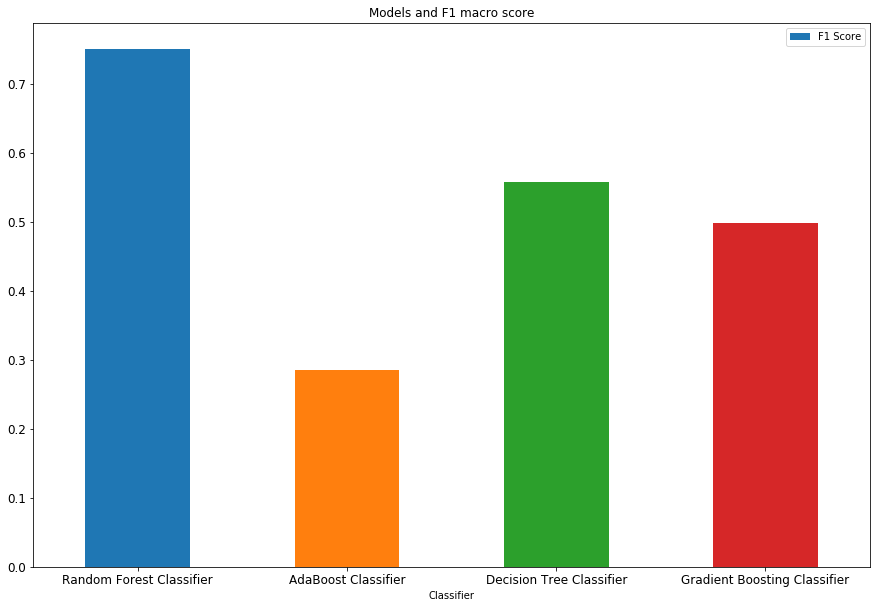

In [290]:
pd.DataFrame(results_data).plot(x='Classifier', y='F1 Score', kind = 'bar', figsize = (15, 10), fontsize = 12)
plt.xticks(rotation = 0)
plt.title('Models and F1 macro score', fontsize = 12)

## Fitting classifiers

In [304]:
airports = np.unique(data['origin'].values)

In [306]:
results = []
for airport in log_progress(airports, every=1):
    try:
        working_df = data[data['origin'] == airport]
        working_df = additional_preprocessing(working_df)
        working_df = process_data(working_df)

        X_train, X_test, y_train, y_test = train_test_split(working_df.loc[:, working_df.columns != 'status'], working_df['status'], test_size = 0.2, random_state = RND_STATE)

        rf_clf.fit(X_train, y_train)

        save_clfs('clfs/' + airport + '.data', rf_clf)
        y_pred = rf_clf.predict(X_test)
        f1_micro = f1_score(y_pred, y_test, average='micro')
        f1_macro = f1_score(y_pred, y_test, average='macro')
        results.append({'airport': airport, 'f1_micro': f1_micro, 'f1_macro': f1_macro})
    except Exception as e:
        print(e)    

VBox(children=(HTML(value=''), IntProgress(value=0, max=304)))

arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
arrays must all be same length
Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required.


In [307]:
results pd.DataFrame(results)

,airport,f1_macro,f1_micro
0,ABE,0.473962,0.934866
1,ABI,1.000000,1.000000
2,ABQ,0.248895,0.939189
3,ABR,0.193220,0.934426
4,ABY,0.720468,0.978378
5,ACT,0.541950,0.924528
6,ACV,0.179679,0.815534
7,ACY,0.243958,0.900000
8,ADK,0.313725,0.888889
9,ADQ,0.322275,0.935780
